# Projet Notations de films 

CECI EST UNE EBAUCHE....

Dans le cadre du Projet Data Science nous avons choisi d'étudier les différents facteurs qui peuvent expliquer ou influencer les notes et appréciations des spectateurs et de la presse attribuées concernant des films.

  

Le rapport se décompose de la manière suivante :   

I - Création de la base de données

1) Webscrapping du site Allocine

2) Traitement et création de variables


II - Analyses descriptive des données

1) 


2)


III - Modélisation

### importation des librairies et fichiers

In [1]:
# Importation des librairies
import csv
import os

# 
import matplotlib.pyplot as plt
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import re
import nest_asyncio


# Regression
import statsmodels.api as sm
from statsmodels.formula.api import rlm 

In [2]:
# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('A_Base_de_données'):
    if f.endswith('.py') and f != 'web_scrapping.py': # A gérer !!!!!
        module_name = os.path.splitext(f)[0]
        exec(f"from A_Base_de_données.{module_name} import *")


for f in os.listdir('B_Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from B_Analyse_descriptive.{module_name} import *")


for f in os.listdir('C_Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from C_Modele.{module_name} import *")


## I - Création de la base de données

### Webscrapping AlloCiné

In [ ]:
# Récupération d'une liste de films qui possèdent tous une note moyenne de spectateur et une note moyenn de presse entre l'année .... et l'année .....
base_films = get_base_films(2010, 2023)


# Récupération pour chaque film de différentes caractériques
nest_asyncio.apply()
base_films_enrichie, presse = get_carac_film(base_films)


In [ ]:
# Exportation en CSV => mettre en commentaire lors du rendu final afin que cela soit toujours le même CSV qui soit utilisé par la suite
from pathlib import Path 
filepath = Path('/home/onyxia/work/Projet_Cin-/A_Base_de_données/base_allociné_2010_2023.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
base_films_enrichie.to_csv(filepath)

In [3]:
# Lecture des bases CSV : 

# Base de films : contenant diverses caractéristiques sur les films
base_films = pd.read_csv('A_Base_de_données/base_films_2010_2023.csv')


# Base presse : contenant la note de chaque presse pour chaque film
presse = pd.read_csv('A_Base_de_données/presse_2010_2023.csv')


### Traitement et création de variables

Base presse

In [4]:
# Traduction des notes en numérique (Très bien => 4, etc)
presse_notes = equivalence_notes(presse)
presse_notes.head()

/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  notes = dataframe.replace(equivalences)


,identifiant,L'Express,Télérama,Brazil,Les Fiches du Cinéma,Les Inrockuptibles,Le Figaroscope,Cahiers du Cinéma,Le Point,Bande à part,...,Libération,Slate,Voici,Studio Magazine,Studio Ciné Live,Dernières Nouvelles d'Alsace,Le Soir,L'Ecran Fantastique,Culturopoing.com,aVoir-aLire.com
0,173528,3,1,NaN,NaN,1,1.0,1,3,NaN,...,1,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
1,146632,2,2,3.0,NaN,1,5.0,1,4,NaN,...,1,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
2,133588,3,3,NaN,NaN,3,4.0,NaN,3,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132039,3,4,3.0,NaN,4,3.0,2,5,NaN,...,3,NaN,NaN,NaN,5,NaN,NaN,2.0,NaN,NaN
4,123534,5,3,4.0,NaN,NaN,4.0,NaN,3,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,4.0,NaN,NaN


base films

In [5]:
# Nettoyage et mise en forme

# Conversion des notes en écriture décimale
base_films['spectateur'] = base_films['spectateur'].apply(mise_en_forme_decimale)
base_films['presse'] = base_films['presse'].apply(mise_en_forme_decimale)



# Créations de variables

# Ajout du genre des réalisateurs (en se basant sur une base de plus de 11 627 prénoms de plusieurs pays dont le genre est mentionné)
table_films = get_genre_individuel(base_films, 'auteur')

# Différence de notation entre spectateur et presse
table_films['diff_notation'] = base_films['spectateur']-table_films['presse']

# Année du film
table_films = get_annee(table_films, 'date')

# Durée du film en minutes
table_films['durée'] = table_films['durée'].astype('string')
table_films['duree_min'] = table_films['durée'].apply(duree_en_minutes)

# Catégorisation de la durée des films
table_films = categorisation_duree(table_films, 'duree_min')

In [6]:
table_films.head()

,genre_ind,titre,identifiant,date,durée,auteur,spectateur,presse,genre1,genre2,...,langues,format_production,couleur,format_audio,format_projection,num_visa,diff_notation,annee,duree_min,duree_cat
0,m,Le Grand jeu,233140,3 janvier 2018,2h 20min,Aaron Sorkin,3.9,3.5,Biopic,Drame,...,Anglais,-,Couleur,-,-,147906,-1.1,2018,140.0,140-149
1,m,Les Sept de Chicago,130085,16 octobre 2020,2h 09min,Aaron Sorkin,4.2,4.4,Drame,Historique,...,Anglais,-,Couleur,-,-,-,-0.8,2020,129.0,120-129
2,m,USS Greyhound - La bataille de l'Atlantique,250108,10 juillet 2020,1h 31min,Aaron Schneider,3.6,2.7,Drame,Historique,...,Anglais,-,Couleur,-,-,-,0.5,2020,91.0,90-99
3,m,Being the Ricardos,289496,21 décembre 2021,2h 05min,Aaron Sorkin,3.3,3.6,Biopic,Drame,...,Anglais,-,Couleur,-,-,-,0.8,2021,125.0,120-129
4,m,Le Secret de la cité perdue,287082,20 avril 2022,1h 52min,Aaron Nee,2.4,2.7,Action,Aventure,...,Anglais,-,Couleur,-,-,156428,1.6,2022,112.0,110-119


La table finale des films contient les colonnes suivantes : 'genre_ind', 'titre', 'identifiant', 'date', 'durée', 'auteur',
       'spectateur', 'presse', 'genre1', 'genre2', 'genre3', 'release',
       'nationalite', 'date_sortie_dvd', 'date_sortie_bluray',
       'date_sortie_vod', 'type_film', 'budget', 'langues',
       'format_production', 'couleur', 'format_audio', 'format_projection',
       'num_visa', 'diff_notation', 'annee', 'duree_min', 'duree_cat'

## II -  Analyses descriptives

### 1) Analyses descriptives générales des films toutes nationalités confondues

Nous avons à notre disposition une base de **5108** films issus d'Allocinés. Avec pour chaque film la **note moyenne** attribuée par les **spectateurs** ainsi que la note moyenne attribuée par **la presse**. Les notes vont de **1 à 5**.

1) Dans un premier temps, nous pouvons regarder quels sont les types de films les plus appréciés en moyenne par les spectateurs : 

In [7]:
# (A noter que les genres dont nous possédons moins de 20 films ne sont pas pris en compte).
classement_genres_preferes(table_films, 'spectateur')

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.472146,219
Animation,3.306024,249
Aventure,3.196238,319
Drame,3.160262,1832
Policier,3.103268,153
Comédie dramatique,3.077961,304
Science Fiction,3.062500,24
Action,3.036791,511
Thriller,2.922034,118


Les films **Biopic**, d'**Animation** et d'**Aventure** semblent être les plus appréciés par les spectateurs. Tandis que les films de **Comédie**, **Fantastique** ou encore d'**Epouvante-horreur** semblent relativement moins appréciés. 

A noter que les effectifs au sein de chaque genre de films peuvent être assez variables (allant de 24 avec la Science Fiction à plus de 1800 pour les Drames). De ce fait, il peut être intéressant de comparer de manière plus précise les **notes moyennes** attribuées par les **spectateurs** afin de voir si les différences dans la **notation des spectateurs** en fonction du **genre de film** sont significatives ou pas. 

Pour cela, nous pouvons regarder la distribution des notes à l'aide d'un **histogramme**, et réaliser un test **ANOVA** sur les différents groupes. Cette méthode statistique permet de déterminer si au moins une des moyennes parmi les groupes étudiés est significativement différente des autres, en tenant compte de la variabilité au sein et entre les groupes.

Dropdown(description='Genre 1 :', index=2, options=('Drame', 'Comédie', 'Action', 'Aventure', 'Comédie dramati…

Dropdown(description='Genre 2 :', index=4, options=('Drame', 'Comédie', 'Action', 'Aventure', 'Comédie dramati…

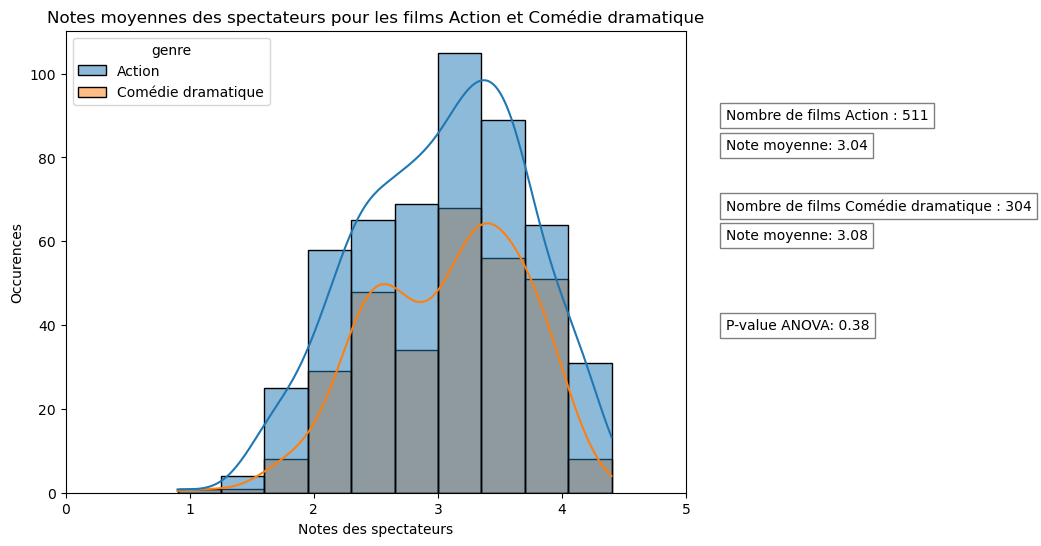

In [8]:
# Histogrammes de la distribution des notes attribuées par les spectateurs en fonction du genre du film
# => Les menus déroulants permettent de sélectionner différents genres à comparer 
# => Les genres dont nous possédons moins de 20 films ne sont pas pris en compte)

graphique_genre_film(table_films)  

Une p-value du test d'ANOVA très faible (inférieure aux seuils usuels, et notamment de 5%), indique que la différence de notation des spectateurs entre les genres de films peut être considérée comme significative. En étudiant les différentes distributions de notes en fonction des genres ainsi que les tests ANOVA associés, nous pouvons remarquer les points suivants :


- L'ANOVA sur tous les types de films montre qu'il existe bien des différences significatives au sein des groupes (au moins un groupe se distingue des autres), cependant cela ne donne aucune information sur quels sont les groupes statistiquement significatifs. Pour cela, nous pouvons par exemple les comparer deux par deux. 


- Certains très proche=> pas significatif ... a continuer  <<<<<<<<>>>>>>>>

- Certains genre de films qui étaient très proches au niveau de la notation moyenne, se retrouvent en fait à avoir des différences de noation qui peuvent être considérées comme statistiquement significatives. C'est notamment le cas du genre Action et Aventure.  p-value 0.04  <<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>

- Mais pour certains couple de genre de films, il n'y a pas de différences significatives (Science Fiction et Action , p-value de 0,89) <<<<<<<<<<<<<<<<<????????????????>>>>>>>>>>>>>>>>>

Les diverses ANOVA réalisées laissent supposer que le type de films semblerait avoir une influence sur la note attribuée par les spectateurs.

2) D'autres caractéristiques pourraient-elles avoir une influence sur l'appréciation attribuée par les spectateurs ?

De manière similaire à précédemment nous pouvons effectuer un test **ANOVA** sur le **genre du réalisateur** afin de voir s'il existe une différence significative dans les notes moyennes attribuées aux films réalisés par des femmes et aux films réalisés par des hommes.

In [12]:
p_value_anova_h_vs_f(table_films)

'P-value du test ANOVA: 0.196'

<<<<<<<<<<<<<<>>>>>>>>>>>>>> COMMENTAIRE

Nous pouvons aussi nous pencher sur la durée des films, en traçant le boxpolt des notes en fonction de la durée des films (durée qui a été discrétisée en intervalle de 10 minutes) : 

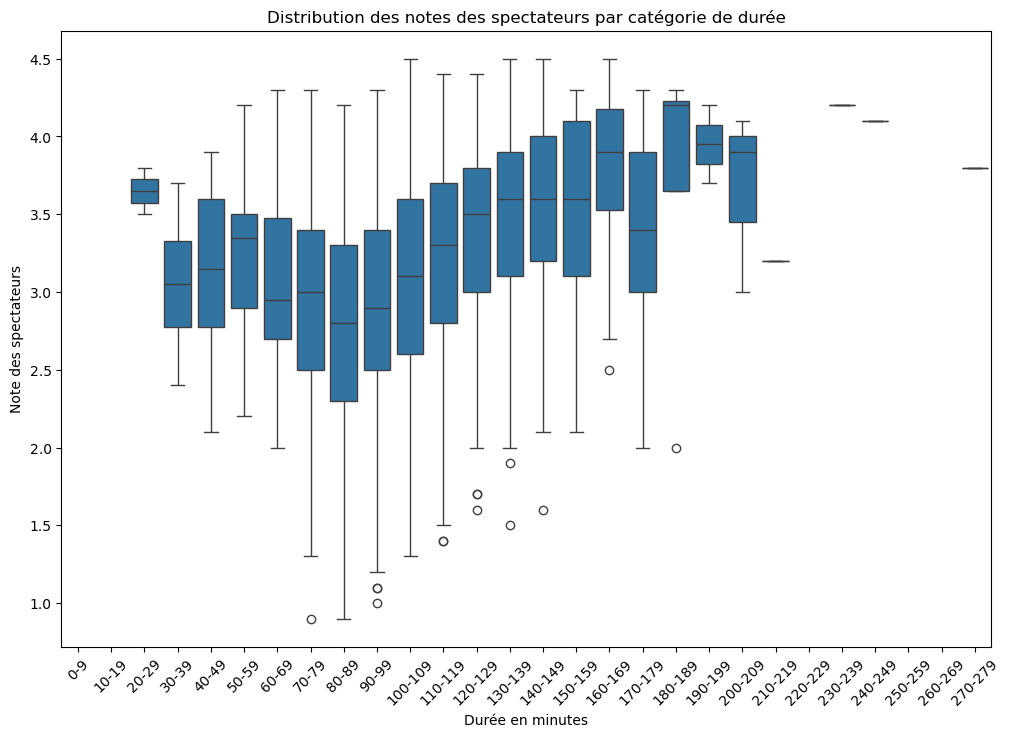

In [23]:
boxplot_duree(table_films, 'duree_cat')

COMMENTAIRES A FAIRE <<<<<<<<<<<<<<<>>>>>>>>>>>>>>>

3) Les préférences des spectateurs sont-elles similaires à celles de la presse ?

Nous avons précédemment regardé le classement des genres de films les plus appréciés par les spectateurs. Comparons maintenant ce classement à celui de la presse :

In [42]:
comparaison_preferences(table_films)

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.472146,219
Animation,3.306024,249
Aventure,3.196238,319
Drame,3.160262,1832
Policier,3.103268,153
Comédie dramatique,3.077961,304
Science Fiction,3.062500,24
Action,3.036791,511
Thriller,2.922034,118


Le classement se ressemble ...........
Cependant les notes moyennes des spectateurs semblent un intervalle plus important que celui de la presse.

Dropdown(description='Genre :', index=12, options=('Drame', 'Comédie', 'Action', 'Aventure', 'Comédie dramatiq…

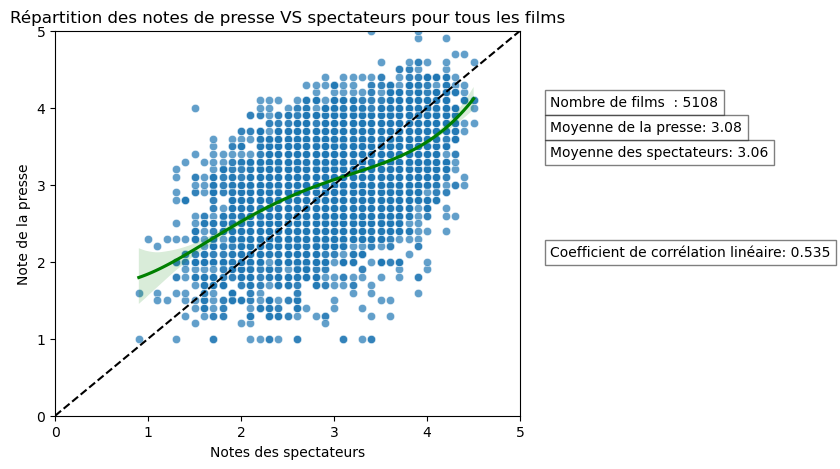

In [ ]:
# Nuage de points pour voir les différences de notations entre la presse et les spectateurs
# =>
# =>
# =>
graphique_presse_vs_spect(table_films) 

COMMENTAIRES =>>>>>>>>>>>>>>>>>>>>>>

### Base CNC : Analyse du type de devis, obtenus par les réalisateurs vs les réalisatrices

Une base du CNC nous donne ce type d'information : les sociétés productrices et distributrices des films, chaînes de télévision partenaires en préachat. Je veux étudier les différences de montant des devis selon le genre du réalisateur.


In [ ]:
#Ici, j'importe les données du CNC en utilisant un API.
import requests
import pandas as pd
api_root = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/cnc-production-cinematographique-liste-des-films-agrees/exports/json?limit=-1"
response = requests.get(api_root)
films_cnc_brut = response.json() #je mets tout dans un dico json
print(response.content[:1000])

films_cnc = pd.json_normalize(films_cnc_brut) 
films_cnc.head(10)

In [ ]:
#Création d'une typologie des devis (je reprends les critères de l'article)
films_cnc["type_de_devis"] = pd.cut(films_cnc.devis, [0,2000000,4000000,7000000, 16000000], right=False)
films_cnc["type_de_devis"]= films_cnc["type_de_devis"].cat.rename_categories(["catégorie 1", "catégorie 2", "catégorie 3", "catégorie 4"])
films_cnc.head()


à noter : dans l'article, ils créent une cinquième catégorie rassemblant "les sociétés de production et les sociétés de distribution qui n’ont produit ou distribué qu’un ou deux longs-métrages d’initiative française sur la période de trois ans étudiée. Cette catégorie 9 regroupe donc des producteurs et des distributeurs qui ont eu une très faible activité sur la période (plusieurs ont eu une courte durée de vie) ou encore des distributeurs liés à des majors américaines pour lesquels la distribution de FIF est une activité marginale. 272 films ont été produits et 70 distribués par de telles sociétés."

Par ailleurs, on peut également faire une typologie en fonction du type de distributeur (voir l'article également).


In [13]:
films_cnc["titre"].nunique()

4600

J'essaie ici de préciser le genre du réalisateur. Dans le cas où le réalisateur est un homme, j'attribue à ma variable genre "m", dans le cas où c'est une femme, j'attribue à ma variable genre "f". Si c'est les deux, "plusieurs réalisateurs".

Je rencontre plusieurs difficultés : déjà j'ai plusieurs réalisateurs par films parfois. J'ai donc essayer de créer une fonction qui me crée une variable par réalisateur (j'ai un petit problème ici). Ensuite l'idée est de créer la variable genre décrite ci-dessus, puis de passer aux analyses.

In [ ]:
#à affiner : créer une colonne réalisateur 2
test = films_cnc["realisateur"].str.split(pat= '/', expand=True) 
test #j'obtiens le nombre de films réalisés par plusieurs réalisateurs

0     2818
1      306
2       21
3        7
4        6
5        5
6        5
7        3
8        1
9        1
10       1
11       1
12       1
dtype: int64


In [ ]:
n_unique_per_column = test.nunique()
print(n_unique_per_column)

In [47]:
realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)
realisateur_split

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,DESPENTES Virginie,None,None,None,None,None,None,None,None,None,None,None,None
1,BENAMOU Nicolas,None,None,None,None,None,None,None,None,None,None,None,None
2,DE MISSOLZ Jérôme,None,None,None,None,None,None,None,None,None,None,None,None
3,SCHOELLER Pierre,None,None,None,None,None,None,None,None,None,None,None,None
4,KLAPISCH Cédric,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,DUQUESNE Vincent,None,None,None,None,None,None,None,None,None,None,None,None
4616,NAKACHE Géraldine,None,None,None,None,None,None,None,None,None,None,None,None
4617,TY Theodore,None,None,None,None,None,None,None,None,None,None,None,None
4618,SAMANI Laura,None,None,None,None,None,None,None,None,None,None,None,None


In [48]:

def add_realisateur_columns(df):
    """
    Cette fonction crée une variable par réalisateur (quand ces derniers sont nombreux)
    """
    # Création d'un dataframe contenant un realisateur par colonne
    realisateur_split = df["realisateur"].str.split(pat='/', expand=True, regex=True)

    # Renommer les colonnes pour correspondre à "réalisateur_1", "réalisateur_2", etc.
    realisateur_split.columns = [f"réalisateur_{i+1}" for i in range(realisateur_split.shape[1])]

    # Remplacer les valeurs manquantes par 0
    realisateur_split = realisateur_split.fillna("0")

    # Ajouter les nouvelles colonnes au DataFrame original
    df = pd.concat([df, realisateur_split], axis=1)

    return df


In [49]:
films_cnc = add_realisateur_columns(films_cnc)
films_cnc

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,réalisateur_4,réalisateur_5,réalisateur_6,réalisateur_7,réalisateur_8,réalisateur_9,réalisateur_10,réalisateur_11,réalisateur_12,réalisateur_13
0,117042,BYE BYE BLONDIE,DESPENTES Virginie,MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,...,0,0,0,0,0,0,0,0,0,0
1,127028,DE L'HUILE SUR LE FEU,BENAMOU Nicolas,AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,...,0,0,0,0,0,0,0,0,0,0
2,124421,DES JEUNES GENS MODERNES,DE MISSOLZ Jérôme,ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,...,0,0,0,0,0,0,0,0,0,0
3,123383,EXERCICE DE L'ETAT (L'),SCHOELLER Pierre,ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,...,0,0,0,0,0,0,0,0,0,0
4,124350,MA PART DU GATEAU,KLAPISCH Cédric,CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,150436,Garder ton nom,DUQUESNE Vincent,ELÉMIAH,1834218.0,Fiction,OUI,1,None,[C+],...,0,0,0,0,0,0,0,0,0,0
4616,149831,J'irai ou tu iras,NAKACHE Géraldine,NORD-OUEST FILMS / MARS CINÉMA,5465545.0,Fiction,OUI,3,None,"[C+, Ciné+]",...,0,0,0,0,0,0,0,0,0,0
4617,148802,Maria,TY Theodore,SIMPATICO (MAIN JOURNEY),27614575.0,Animation,OUI,1,None,[C+],...,0,0,0,0,0,0,0,0,0,0
4618,151720,Small body,SAMANI Laura,TOMSA FILMS,2062780.0,Fiction,NON,1,None,None,...,0,0,0,0,0,0,0,0,0,0


In [52]:
films_cnc.columns

Index(['visa', 'titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof',
       'rang', 'asr', 'payante', 'clair', 'nationalite', 'date',
       'decomposition', 'aides', 'type_de_devis', 'réalisateur_1',
       'réalisateur_2', 'réalisateur_3', 'réalisateur_4', 'réalisateur_5',
       'réalisateur_6', 'réalisateur_7', 'réalisateur_8', 'réalisateur_9',
       'réalisateur_10', 'réalisateur_11', 'réalisateur_12', 'réalisateur_13',
       'réalisateur_1', 'réalisateur_2', 'réalisateur_3', 'réalisateur_4',
       'réalisateur_5', 'réalisateur_6', 'réalisateur_7', 'réalisateur_8',
       'réalisateur_9', 'réalisateur_10', 'réalisateur_11', 'réalisateur_12',
       'réalisateur_13', 'réalisateur_1', 'réalisateur_2', 'réalisateur_3',
       'réalisateur_4', 'réalisateur_5', 'réalisateur_6', 'réalisateur_7',
       'réalisateur_8', 'réalisateur_9', 'réalisateur_10', 'réalisateur_11',
       'réalisateur_12', 'réalisateur_13', 'réalisateur_1', 'réalisateur_2',
       'réalisateur_3', 'ré

In [ ]:
films_cnc["réalisateur_13"] = films_cnc["réalisateur_13"].astype(str) #je convertis tout en chaîne de caractère

In [51]:
films_cnc["réalisateur_13"].nunique()

réalisateur_13    2
réalisateur_13    2
réalisateur_13    2
réalisateur_13    2
dtype: int64

In [50]:
films_cnc.loc[films_cnc["réalisateur_13"] != "0"]


ValueError: Cannot index with multidimensional key

Je vais éliminer de l'analyse les films réalisés par plus de 3 réalisateurs. Au total, j'en ai ...

In [ ]:
#J'intègre le genre dans ma base de données
def get_genre_individuel(dataframe, colonne, position):
    """  
    """
    base_prenom_genre = base_prenom()
    base_prenom_genre = base_prenom_genre.drop(columns=['04_fréquence'])

    # transformation du prénom en minuscule
    dataframe['prenom'] = dataframe[colonne].str.split().str[position].str.lower()

    base_avec_genre = pd.merge(base_prenom_genre, dataframe, on='prenom', how='inner')
    base_avec_genre_nettoyée = base_avec_genre.drop(labels='prenom', axis='columns')
    return base_avec_genre_nettoyée



In [ ]:
films_cnc_avec_genre = get_genre_individuel(films_cnc, 'realisateur', -1)
films_cnc_avec_genre

In [ ]:
films_cnc_avec_genre.size

films_cnc_avec_genre['genre_ind'].value_counts()


### Fusion base CNC et base allociné

J'effectue un test pour voir si la base CNC et la base allociné peuvent bien être fusionnées. Je récupère donc ces informations : ttes les infos cnc, les moyennes des notes presse et spectateur allociné. 

In [19]:
#Préparation de la base allociné pour le merge 
base_films_2010 = get_base_films(2010, 2010)
nest_asyncio.apply()
base_films_enrichie_2010 = get_carac_film(base_films_2010)

base_films_enrichie_2010['num_visa'] = base_films_enrichie_2010['num_visa'].str.replace(' ', '')

nombre de films récupérés :  491


In [23]:
inner_merge_cnc_allociné = pd.merge(left = films_cnc , right = base_films_enrichie_2010 , how='inner', left_on="visa", right_on='num_visa')

In [24]:
inner_merge_cnc_allociné

,visa,titre_x,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,date_sortie_bluray,date_sortie_vod,type_film,budget,langues,format_production,couleur,format_audio,format_projection,num_visa
0,122207,AO LE DERNIER NEANDERTAL,MALATERRE Jacques,FRANCE 2 CINEMA / UGC IMAGES / UGC YM,13398412.0,Fiction,None,1,None,None,...,-,01/12/2016,Long métrage,13 000 000 EUR,Français,-,Couleur,-,-,122207
1,122530,COURSIER,RENOH Hervé,BLACK MASK PRODUCTIONS / EUROPACORP / M6 FILMS...,9410932.0,Fiction,None,2,None,None,...,-,03/12/2019,Long métrage,-,Français,-,Couleur,-,-,122530
2,121405,MEUTE (LA),RICHARD Franck,LA FABRIQUE 2,2866560.0,Fiction,None,1,None,None,...,-,01/01/2016,Long métrage,2 500 000 EUR,Français,-,Couleur,-,-,121405
3,123656,REVOLTES DE L'ILE DU DIABLE (LES),HOLST M.,MACT PRODUCTIONS,5296837.0,Fiction,None,3,None,None,...,24/10/2012,23/03/2012,Long métrage,9 500 000 USD,"Norvégien, Suédois",-,Couleur,-,-,123656
4,120962,TOURNEE,AMALRIC Mathieu,ARTE FRANCE CINEMA / LE PREMIER POISSON,3515910.0,Fiction,None,2,avant,None,...,29/09/2016,30/10/2010,Long métrage,4 150 000 EUR,"Anglais, Français",35mm,Couleur,Dolby Digital,1.85 : 1,120962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,124018,MAMMUTH,KERVERN Gustave / DELEPINE Benoît,ARTE FRANCE CINEMA / DD PRODUCTIONS / GMT PROD...,2499161.0,Fiction,None,3 / 3,None,None,...,-,15/08/2015,Long métrage,2 000 000 USD,Français,35mm,Couleur,Dolby Digital,1.85 : 1,124018
164,121731,TETE AILLEURS (LA),PELLE Frédéric,7EME APACHE FILMS / BIANCA FILMS,1054741.0,Fiction,None,1,None,None,...,-,-,Long métrage,-,Français,-,Couleur,-,-,121731
165,123205,TETE EN FRICHE (LA),BECKER Jean,DD PRODUCTIONS / FRANCE 3 CINEMA / ICE 3 / KJB...,8274491.0,Fiction,None,3,None,None,...,-,23/10/2010,Long métrage,-,"Flamand, Français",35mm,Couleur,"Dolby Digital, DTS",2.35 : 1 Cinemascope,123205
166,122965,UN HOMME QUI CRIE,HAROUN Mahamat-Saleh,PILI FILMS,2066392.0,Fiction,None,3,avant,None,...,-,29/01/2011,Long métrage,2 000 000 EUR,Français,-,Couleur,-,-,122965


## III - Modelisation

La première partie de l'analyse descriptive montre que .... => modèle qui essaie de prédire la note en se bassant sur divers critère :
régression

In [45]:
table_films.columns

Index(['genre_ind', 'titre', 'identifiant', 'date', 'durée', 'auteur',
       'spectateur', 'presse', 'genre1', 'genre2', 'genre3', 'release',
       'nationalite', 'date_sortie_dvd', 'date_sortie_bluray',
       'date_sortie_vod', 'type_film', 'budget', 'langues',
       'format_production', 'couleur', 'format_audio', 'format_projection',
       'num_visa', 'diff_notation', 'annee', 'duree_min'],
      dtype='object')

In [87]:
table_cluster = pd.merge(table_films[['identifiant','genre1']], presse_notes, on = 'identifiant', how='left')
table_cluster = table_cluster.drop(columns=table_cluster.columns[0])

note_columns = table_cluster.columns
note_columns = note_columns.drop('genre1')

# # # table_cluster.replace(['NaN', 'Nan'], np.nan, inplace=True)
for col in note_columns:
    table_cluster[col] = pd.to_numeric(table_cluster[col], errors='coerce')

    
result = table_cluster.groupby('genre1').mean().reset_index()
result

,genre1,L'Express,Télérama,Brazil,Les Fiches du Cinéma,Les Inrockuptibles,Le Figaroscope,Cahiers du Cinéma,Le Point,Bande à part,...,Libération,Slate,Voici,Studio Magazine,Studio Ciné Live,Dernières Nouvelles d'Alsace,Le Soir,L'Ecran Fantastique,Culturopoing.com,aVoir-aLire.com
0,Action,2.683230,2.537764,2.538462,2.782772,2.709091,3.190476,2.252101,2.815789,3.416667,...,2.515464,NaN,3.480000,2.000000,2.793103,3.387097,NaN,3.509317,3.068966,2.876190
1,Animation,3.581818,3.442623,2.500000,3.529412,3.321429,3.733333,3.148936,3.725000,4.080000,...,3.396825,NaN,3.897436,NaN,3.250000,3.764706,NaN,3.428571,3.941176,3.441176
2,Aventure,3.067416,2.946667,3.083333,3.251429,2.682540,3.518519,2.467742,3.452055,4.000000,...,2.950980,NaN,3.687500,5.000000,3.100000,3.596154,NaN,3.459770,3.625000,3.045113
3,Biopic,3.366337,3.026882,2.666667,3.227545,2.792857,3.941176,2.517241,3.810811,3.931818,...,3.030534,NaN,3.733333,5.000000,3.185185,3.875000,NaN,3.750000,3.820513,3.368794
4,Bollywood,4.000000,2.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN
5,Comédie,3.098802,2.908093,2.736842,2.990148,2.960707,3.237037,2.549849,3.473958,3.814286,...,3.020408,NaN,3.731481,4.428571,2.826772,3.588571,NaN,3.140000,3.648649,3.131034
6,Comédie dramatique,3.075630,3.086420,2.941176,3.089005,3.105263,3.397059,2.408333,3.591549,3.656250,...,3.066667,NaN,3.863636,NaN,3.022989,3.689655,NaN,4.500000,3.600000,3.389706
7,Comédie musicale,4.000000,2.666667,NaN,4.000000,3.000000,5.000000,4.000000,3.000000,4.000000,...,3.666667,NaN,4.500000,NaN,5.000000,4.000000,NaN,NaN,4.000000,3.000000
8,Divers,NaN,4.000000,NaN,1.000000,2.000000,NaN,4.000000,NaN,NaN,...,4.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2.000000
9,Drama,2.000000,5.000000,NaN,4.000000,5.000000,NaN,5.000000,4.000000,NaN,...,4.000000,NaN,5.000000,NaN,2.000000,NaN,NaN,4.000000,NaN,4.000000
